In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from matplotlib.pyplot import figure

In [2]:
con = sqlite3.connect("database.sqlite")
trips_df = pd.read_sql_query("SELECT * from trip", con)

In [3]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4069,174,8/29/2013 9:08,2nd at South Park,64,8/29/2013 9:11,2nd at South Park,64,288,Subscriber,94114
1,4073,1067,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:42,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703
2,4074,1131,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115
3,4075,1117,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122
4,4076,1118,8/29/2013 9:25,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597


In [4]:
ids = pd.read_sql_query("SELECT DISTINCT(id) from station", con)

In [5]:
reverse = {}
for i in range(ids.shape[0]):
    j = int(ids.iloc[i])
    reverse[j] = i

In [6]:
adjm = np.zeros((len(reverse),len(reverse)))
for i,row in trips_df.iterrows():
    if i%10000 == 0:print(i)
    adjm[reverse[row.start_station_id], reverse[row.end_station_id]] += 1

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000


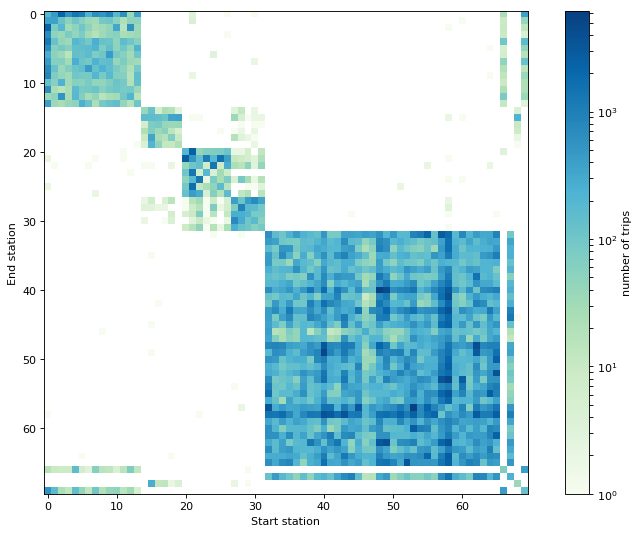

In [44]:
figure(figsize=(12, 8), dpi=80)
plt.imshow(adjm, norm=matplotlib.colors.LogNorm(), cmap=plt.get_cmap('GnBu'))
cbar = plt.colorbar()
cbar.set_label('number of trips', rotation=90)
plt.xlabel('Start station')
plt.ylabel('End station')
plt.show()

In [8]:
adj_homo = np.zeros((len(reverse),len(reverse)))
for i in range(len(reverse)):
    for j in range(len(reverse)):
        aij = adjm[i,j]
        #norm = np.sqrt(adjm[i,:].sum() * adjm[:,j].sum())
        norm = 1/(1/adjm[i,:].sum() + 1/adjm[:,j].sum())
        adj_homo[i,j] = aij / norm

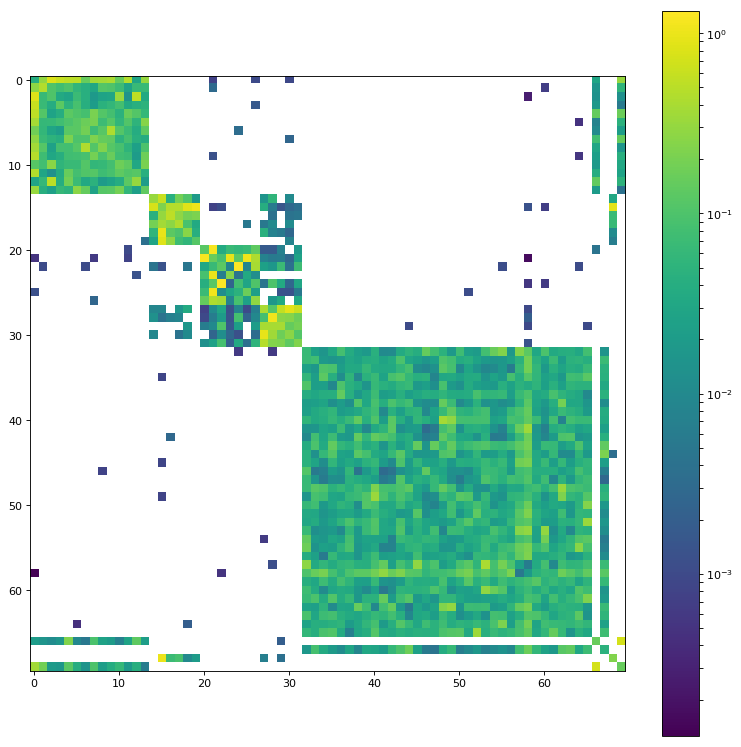

In [9]:
figure(figsize=(12, 12), dpi=80)
plt.imshow(adj_homo, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

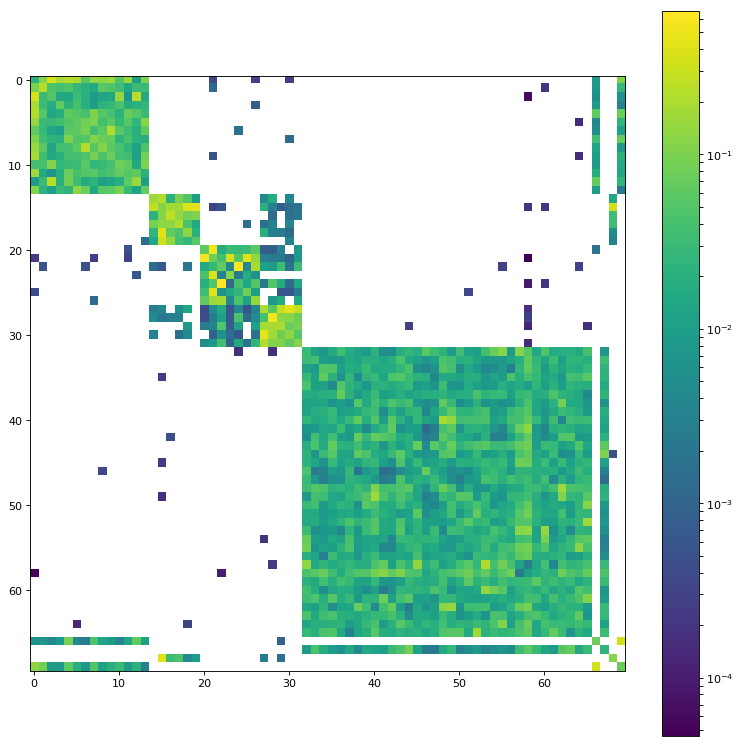

In [10]:
adj_homo = np.zeros((len(reverse),len(reverse)))
for i in range(len(reverse)):
    for j in range(len(reverse)):
        aij = adjm[i,j]
        norm = np.sqrt(adjm[i,:].sum() * adjm[:,j].sum())
        #norm = 1/(1/adjm[i,:].sum() + 1/adjm[:,j].sum())
        adj_homo[i,j] = aij / norm
figure(figsize=(12, 12), dpi=80)
plt.imshow(adj_homo, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [11]:
trip_df = pd.read_sql_query("""
        SELECT t.start_station_id, t.end_station_id, t.start_date, t.end_date, s1.long, s1.lat, s2.long, s2.lat from trip as t 
        JOIN station AS s1, station AS s2 ON t.start_station_name = s1.name AND t.end_station_name = s2.name 
        WHERE s1.name <> s2.name""", con)

In [12]:
import matplotlib.pyplot as plt
np_array = trip_df.values

from math import radians, cos, sin, asin, sqrt
from datetime import datetime

def haversine(lon1, lat1, lon2, lat2):
  # convert decimal degrees to radians
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

  # haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a))
  r = 6371 # Radius of earth in kilometers. Use 3956 for miles
  return c * r

def timify(time):
    time = time.split('/')
    time[2] = time[2].split(':')
    t1 = datetime(int(time[2][0][0:4]), int(time[0]), int(time[1]), int(time[2][0][-2:]), int(time[2][-1]))
    return t1

def timer(t1, t2):
    return t2-t1

first = np_array[0]

def vitesse(obj):
    obj = obj[2:]
    return timer(timify(obj[0]), timify(obj[1])).total_seconds()/3600 / haversine(obj[2], obj[3], obj[4], obj[5])

In [13]:
trip_df.head(3)

,start_station_id,end_station_id,start_date,end_date,long,lat,long,lat
0,66,69,8/29/2013 9:24,8/29/2013 9:42,-122.418954,37.774814,-122.39547,37.7766
1,66,69,8/29/2013 9:24,8/29/2013 9:43,-122.418954,37.774814,-122.39547,37.7766
2,66,69,8/29/2013 9:24,8/29/2013 9:43,-122.418954,37.774814,-122.39547,37.7766


In [14]:
n = len(reverse)
adj_speeds = [[[] for _ in range(n)] for _ in range(n)]
for i,row in trip_df.iterrows():
    v = vitesse(row.values)
    if i%10000 == 0:print(i)
    adj_speeds[reverse[row.start_station_id]][reverse[row.end_station_id]].append(v)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000


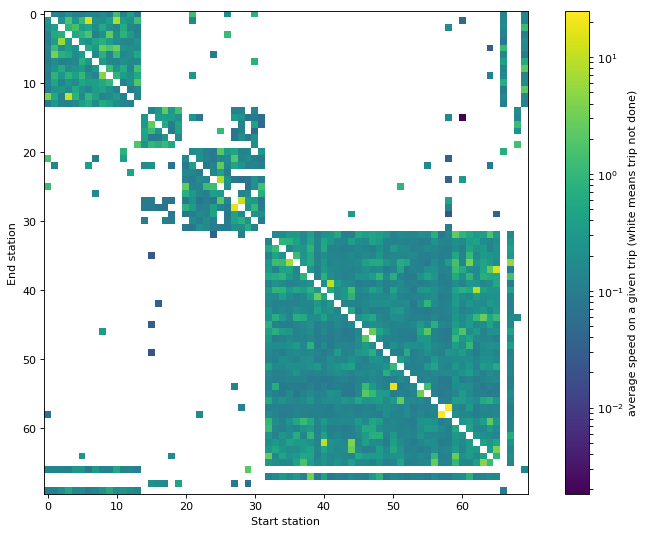

In [52]:
avg_speeds = np.zeros((len(reverse),len(reverse)))
for i in range(len(reverse)):
    for j in range(len(reverse)):
        avg_speeds[i,j] = sum(adj_speeds[i][j])/len(adj_speeds[i][j]) if len(adj_speeds[i][j]) >0 else -1

from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
avg_speeds = np.minimum(25,avg_speeds)
plt.imshow(avg_speeds, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label('average speed on a given trip (white means trip not done)', rotation=90)
plt.xlabel('Start station')
plt.ylabel('End station')
plt.show()

In [50]:
bi_station_df = pd.read_sql_query("""
        SELECT s1.id AS id1, s2.id as id2, s1.long, s1.lat, s2.long, s2.lat FROM 
        station AS s1, station AS s2""", con)

In [17]:
bi_station_df.head(3)

,id1,id2,long,lat,long,lat
0,2,2,-121.901782,37.329732,-121.901782,37.329732
1,2,3,-121.901782,37.329732,-121.888979,37.330698
2,2,4,-121.901782,37.329732,-121.894902,37.333988


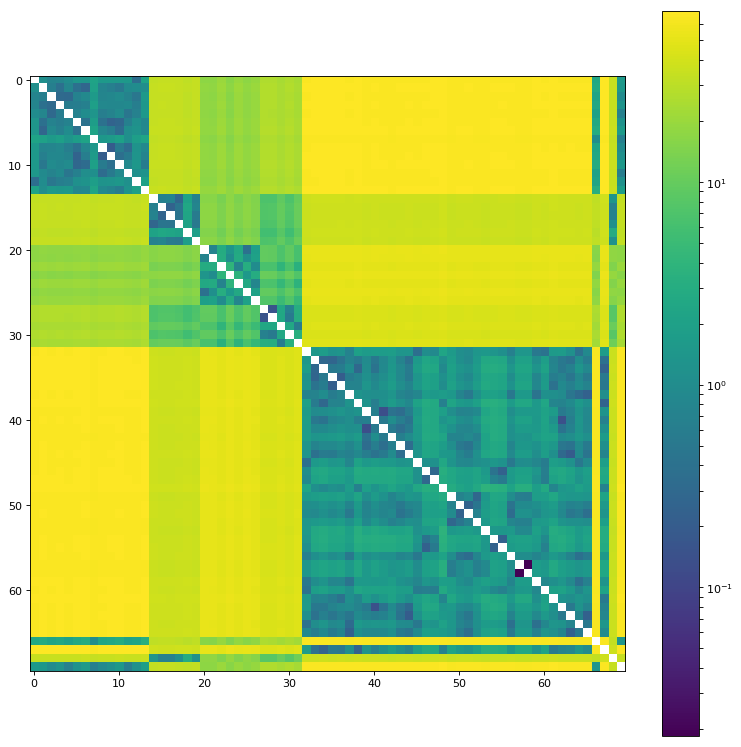

In [18]:
dists = np.zeros((len(reverse),len(reverse)))
for i,row in bi_station_df.iterrows():
    dists[reverse[row.id1],reverse[row.id2]] = haversine(*row.values[2:])



figure(figsize=(12, 12), dpi=80)
plt.imshow(dists, norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [19]:
bi_station_speed = list(avg_speeds.reshape((-1)))
log_bi_station_speed = [np.log(x) for x in bi_station_speed if x>0]

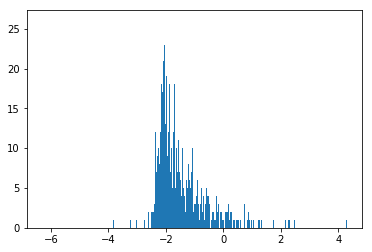

In [56]:
plt.hist(log_bi_station_speed, bins=1000)
plt.show()

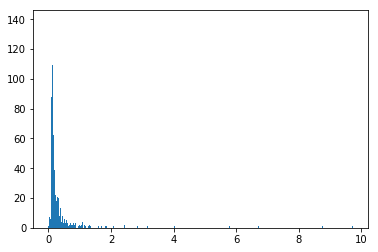

In [57]:
plt.hist([x for x in bi_station_speed if x>0 and x<10], bins=1000)
plt.show()

In [22]:
import csv
import numpy as np

n_buckets = 100
fullness = [[0]*101 for _ in range(n)]

i = 0
with open('status.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        if i>0:
            if (int(row[1])+int(row[2])) > 0:
                perc = int(row[1])/(int(row[1])+int(row[2]))
                id = int(row[0])
                b = int(perc*n_buckets)
                fullness[reverse[id]][b] += 1
        
        i+=1
        if i%1000000==0:
            print(i, row)

1000000 ['5', '8', '11', '2014/01/30 19:35:02']
2000000 ['9', '7', '8', '2014/01/01 12:32:02']
3000000 ['13', '8', '7', '2013/12/03 09:12:03']
4000000 ['22', '12', '15', '2013/11/04 05:46:03']
5000000 ['26', '9', '6', '2013/10/05 15:22:03']
6000000 ['30', '8', '7', '2013/09/05 06:25:01']
7000000 ['35', '6', '5', '2013/10/09 07:41:01']
8000000 ['41', '6', '9', '2013/09/09 09:59:02']
9000000 ['46', '11', '4', '2014/02/09 13:14:02']
10000000 ['50', '15', '8', '2014/01/11 09:13:02']
11000000 ['55', '17', '6', '2013/12/13 02:50:02']
12000000 ['59', '11', '12', '2013/11/13 23:23:02']
13000000 ['63', '8', '11', '2013/10/15 12:08:01']
14000000 ['67', '6', '21', '2013/09/15 19:56:01']
15000000 ['70', '5', '14', '2014/02/15 15:11:02']
16000000 ['74', '9', '10', '2014/01/17 11:15:02']
17000000 ['2', '12', '15', '2014-03-04 18:00:01']
18000000 ['5', '13', '6', '2014-07-30 13:22:02']
19000000 ['9', '5', '10', '2014-06-24 10:36:03']
20000000 ['13', '7', '8', '2014-05-19 06:00:03']
21000000 ['22', '1

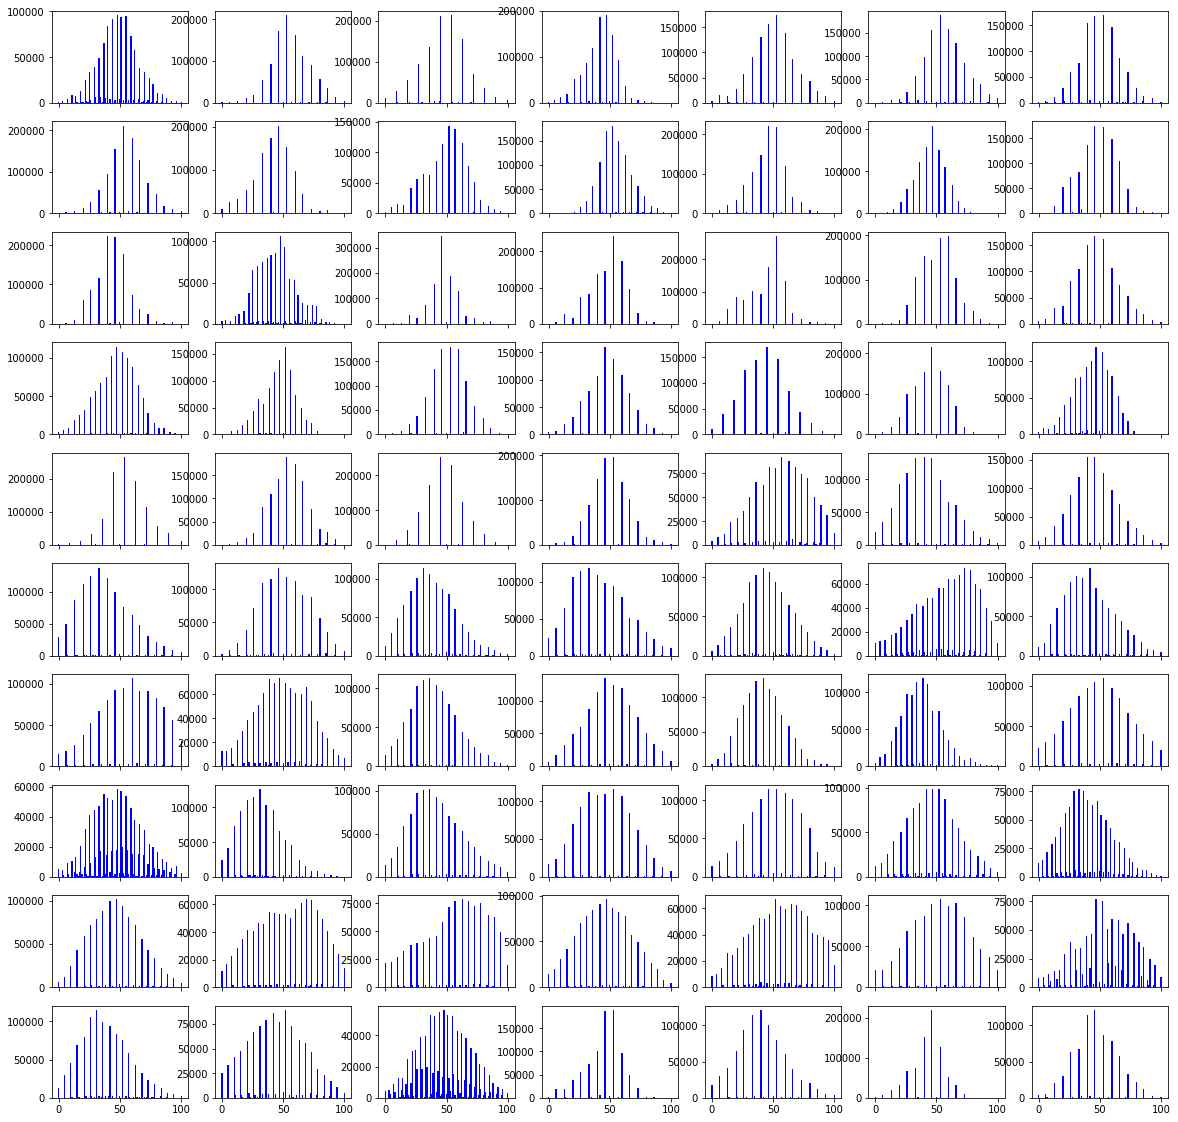

In [23]:
X = np.arange(101)
fig, axs = plt.subplots(10,7,figsize=(20,20),sharex=True)
for i in range(n):
    #axs[i//10, i%10].bar(X + 0.01*i, fullness[i], color = 'b', width = 0.01)
    axs[i//7, i%7].bar(X, fullness[i], color = 'b', width = 1)
plt.show()

In [24]:
n

70

In [67]:
print(np.argmax(np.array([f[0]/sum(f) for f in fullness])))

35


In [62]:
fullness[0][0]

1340

In [63]:
fullness[67][0]

17824

In [66]:
print([f[0]/sum(f) for f in fullness])

[0.0012799718788267815, 0.0010180372127936526, 0.010140387737560883, 0.0012615289998873123, 0.003403549852837533, 0.0001871761422997072, 0.0008551745224877457, 0.0007019112039352867, 0.009377915677067368, 0.0016884068143640637, 2.8649436895317824e-06, 0.0011287878136755222, 9.645310421423667e-05, 0.0002225106265536351, 8.976823560532918e-05, 0.0035487102501000345, 0.00017189662137190694, 0.0005568561601376953, 0.0009454314175454881, 6.684868608907492e-06, 0.0047071024819007184, 0.003104643978222608, 0.0007181458848426334, 0.0004899053709099347, 0.004627193359587726, 0.011461722043783571, 0.000723875772221697, 0.002659622725115338, 0.001499326258168702, 7.544351715767026e-05, 0.0009941354602675285, 2.8649436895317824e-06, 0.004283782183286659, 0.018221041865422134, 0.006666723965540457, 0.027883541948982994, 0.0018612584169658145, 0.012111071956880687, 0.023302496989421672, 0.005247621857992381, 0.009842679501151417, 0.010137205632249069, 0.014144226995218409, 0.012090937771871623, 0.01

Text(0,0.5,'Number of minutes in that state')

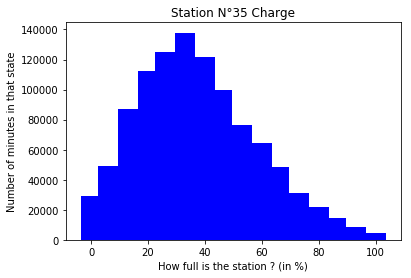

In [72]:
plt.bar(X, fullness[35], color = 'b', width = 7)
plt.title('Station N°35 Charge')
plt.xlabel('How full is the station ? (in %)')
plt.ylabel('Number of minutes in that state')